In [1]:
import sys
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu

%matplotlib inline

In [2]:
config1 = "ns_3_mreg_5_msub_0_nf_32"
conn1 = "linw"

config2 = "ns_3_mreg_3_msub_5_nf_32"
conn2 = "logwhom"

preproc = "dicer"
modelname = "AB"

run = 0

ds1 = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn1}_{preproc}/dataset.npz")
ds2 = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn2}_{preproc}/dataset.npz")

direc1 = f"../run/hcp/hcp100_{conn1}_{preproc}/model{modelname}/{config1}/run{run:02d}"
direc2 = f"../run/hcp/hcp100_{conn2}_{preproc}/model{modelname}/{config2}/run{run:02d}"

In [3]:
isubs = np.r_[0:100]

epochs = [0, 200, 400, 600, 800, 1000]
thetaregs = []
thetasubs = []

for epoch in epochs:
    model1 = util.get_model(modelname, config1, ds1)
    model1.load_weights(os.path.join(direc1, f"fit/models/model_{epoch:05d}"))
    params = model1.encode_subjects(ds1.w[isubs], ds1.y[isubs], isubs)
    if epoch == 0:
        params.thetareg[:,:,:,0] = 0
        params.thetareg[:,:,:,1] = 1
    thetaregs.append(params.thetareg)
    
    model2 = util.get_model(modelname, config2, ds2)
    model2.load_weights(os.path.join(direc2, f"fit/models/model_{epoch:05d}"))
    params = model2.encode_subjects(ds2.w[isubs], ds2.y[isubs], isubs)
    thetasubs.append(params.thetasub)
    if epoch == 0:
        params.thetasub[:,:,0] = 0
        params.thetasub[:,:,1] = 1

2022-08-13 22:10:11.413965: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 22:10:11.414890: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
def plot_crosses(ax, x, **args):
    plt.sca(ax)
    n, _, _ = x.shape
    assert x.shape == (n, 2, 2)
    for i in range(n):
        plt.plot([x[i,0,0]-x[i,0,1], x[i,0,0]+x[i,0,1]], [x[i,1,0], x[i,1,0]], **args)
        plt.plot([x[i,0,0], x[i,0,0]], [x[i,1,0]-x[i,1,1], x[i,1,0]+x[i,1,1]], **args)

In [5]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [13]:
def plot_params(ax, theta, label, show_label=False):
    plt.sca(ax)
    plot_crosses(ax, theta, color='k', lw=0.5)
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xticks([-2,0,2])
    if show_label:
        plt.yticks([-2,0,2])
        plt.ylabel(label, rotation=False, va='center', labelpad=20)
    else:
        plt.yticks([])
    
    circle = plt.Circle((0, 0), 1, ec='tab:blue', fc='none', lw=0.6, zorder=-5)
    ax.add_patch(circle)
    ax.set_aspect('equal')

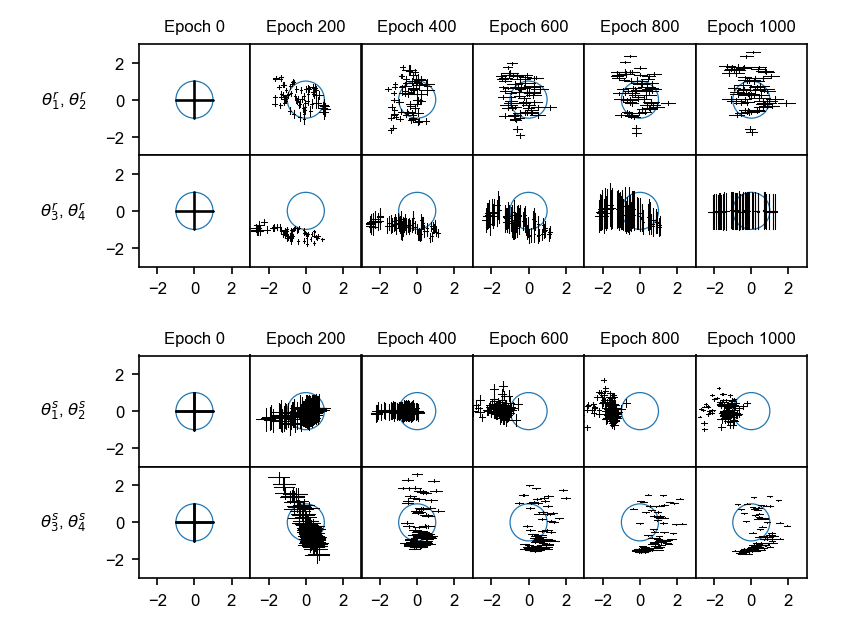

In [14]:
plt.figure(figsize=(5.5,4.), dpi=150)

gs = GridSpec(nrows=5, ncols=len(epochs), left=0.15, right=0.96, bottom=0.06, top=0.95, hspace=0., wspace=0.,
             height_ratios=[1,1,0.8,1,1])

isub = 2

for i, (epoch, thetareg, thetasub) in enumerate(zip(epochs, thetaregs, thetasubs)):
    ax = plt.subplot(gs[0,i])
    plot_params(ax, thetareg[isub][:,[1,4],:], r"$\theta^r_1$, $\theta^r_2$", show_label=(i==0))
    plt.title(f"Epoch {epoch}")
    
    ax = plt.subplot(gs[1,i])
    plot_params(ax, thetareg[isub][:,[0,2],:], r"$\theta^r_3$, $\theta^r_4$", show_label=(i==0))
    
    ax = plt.subplot(gs[3,i])
    plot_params(ax, thetasub[:,[0,1],:], r"$\theta^s_1$, $\theta^s_2$", show_label=(i==0))
    plt.title(f"Epoch {epoch}")
    
    ax = plt.subplot(gs[4,i])
    plot_params(ax, thetasub[:,[3,4],:], r"$\theta^s_3$, $\theta^s_4$", show_label=(i==0))
    
    
bg = pu.Background(visible=False)
plt.savefig("img/Fig_HCP-SubjectParameters.pdf")